# Projekt LLM 25L - Klasyfkacja tekstu na wybranym zbiorze danych

## Adam Kraś 325177

In [1]:
import torch
import torch.nn as nn
import datasets
import evaluate
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Fri May 23 13:00:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              3W /   55W |      18MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
# Wczytanie wybranego zbioru danych
dataset = datasets.load_dataset("community-datasets/yahoo_answers_topics")

In [28]:
dataset["train"][42]  # Wyświetlenie przykładu z zestawu danych

{'id': 42,
 'topic': 6,
 'question_title': 'When will Google buy Yahoo?',
 'question_content': 'The two businesses are very complementary in terms of strengths and weaknesses. Do we want to beat ourselves up competing with each other for resources and market share, or unite to beat MSFT?',
 'best_answer': "Their respective market caps are too close for this to ever happen.\\nInterestingly, many reporters, analysts and tech pundits that I talk to think that the supposed competition between Google and Yahoo is fallacious, and that they are very different companies with very different strategies. Google's true competitor is often seen as being Microsoft, not Yahoo. This would support your claim that they are complementary."}

Computers & Internet: 140000
Sports: 140000
Health: 140000
Business & Finance: 140000
Science & Mathematics: 140000
Entertainment & Music: 140000
Education & Reference: 140000
Family & Relationships: 140000
Politics & Government: 140000
Society & Culture: 140000


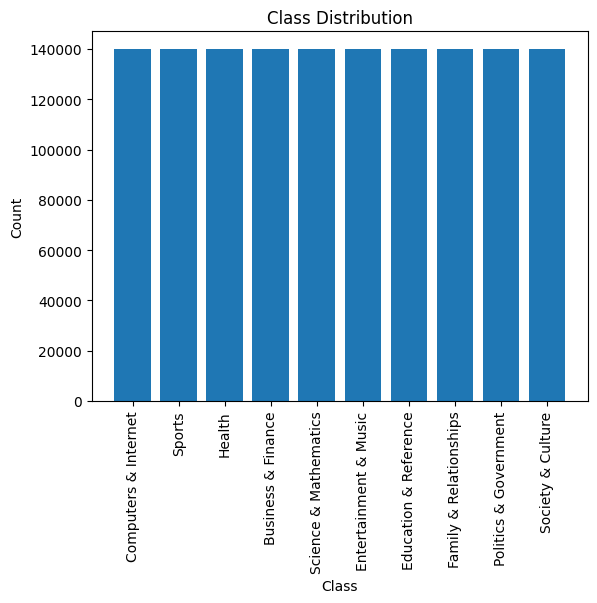

In [29]:
labels = dataset["train"]["topic"]
label_counts = Counter(labels)
label_names = dataset["train"].features["topic"].names

for label_id, count in label_counts.items():
    print(f"{label_names[label_id]}: {count}")

labels_text = [label_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.bar(labels_text, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [30]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Porównanie rozmiarów zbiorów danych treningowego i testowego
print(f"Dataset size: {len(train_dataset) + len(test_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset)) * 100:.2f}%")

Dataset size: 1460000
Train dataset size: 95.89%
Test dataset size: 4.11%


Jak widzimy, stosunek rozmiarów zbioru treningowego i testowego są dalekie od idealnych. Ponadto, nie ma zbioru walidaycjnego. Zróbmy coś z tym.

Jednakże, przed podzieleniem zbioru danych na nowo, przetestujemy różne zredukowane jego rozmiarym, gdyż prawie 1,5 miliona elementów to zddecydowanie więcej niż wynosi optymalny pod względem obliczeniowym i efektywnościowym rozmiar zbioru do klasyfikacji 10-klasowej.

In [31]:
dataset_size = 20000

reduced_train = train_dataset.train_test_split(
    train_size=dataset_size,
    test_size=dataset_size // 5,
    stratify_by_column="topic",
    shuffle=True,
    seed=42
)["train"]

train_dataset = reduced_train

Potwierdźmy czy balans klas został zachowany po zmniejszeniu rozmiaru zbioru danych

Society & Culture: 2000
Health: 2000
Family & Relationships: 2000
Sports: 2000
Business & Finance: 2000
Computers & Internet: 2000
Education & Reference: 2000
Politics & Government: 2000
Entertainment & Music: 2000
Science & Mathematics: 2000


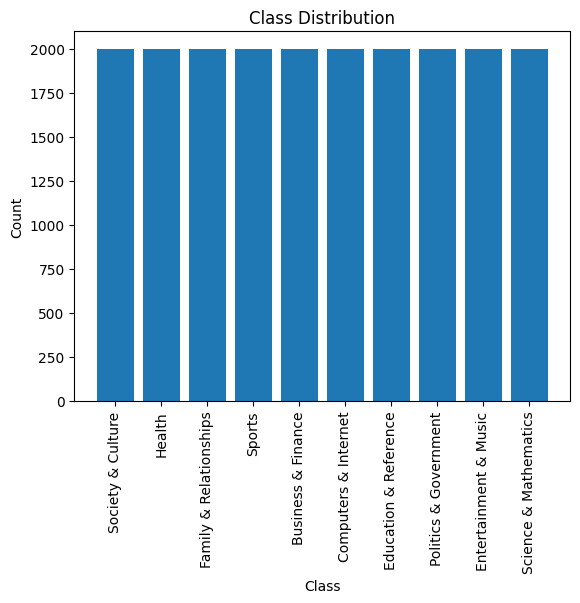

In [32]:
labels = train_dataset["topic"]
label_counts = Counter(labels)
label_names = train_dataset.features["topic"].names

for label_id, count in label_counts.items():
    print(f"{label_names[label_id]}: {count}")

labels_text = [label_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.bar(labels_text, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [33]:
full_split = train_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = full_split["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = full_split["train"]
val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

# Sprawdzenie rozmiarów zbiorów danych po podziale
print(f"Dataset size: {len(train_dataset) + len(test_dataset) + len(val_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Validation dataset size: {len(val_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")

Dataset size: 20000
Train dataset size: 80.00%
Test dataset size: 10.00%
Validation dataset size: 10.00%


In [34]:
# Przygotowanie modelu
q_config = BitsAndBytesConfig(load_in_8bit=True)

base_model_id = "google-bert/bert-base-uncased"

# model = AutoModelForCausalLM.from_pretrained(
#     base_model_id,
#     quantization_config=q_config,
#     torch_dtype=torch.float16,
#     trust_remote_code=True,
# )

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id,
    num_labels=10,
    # torch_dtype=torch.float16,
    id2label={i: label_names[i] for i in range(10)},
    label2id={label_names[i]: i for i in range(10)},
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
print(model)

print(f"\n\nZajętość pamięci przez model: {model.get_memory_footprint() / 1024**3:0.3f}GB")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [36]:
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.pad_token_id = tokenizer.pad_token_id
print(f"Rozmiar słownika: {tokenizer.vocab_size}")

Rozmiar słownika: 30522


In [37]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
# Sprawdzenie długości tokenów w zbiorze danych
# print(f"Maksymalna obsługiwana długość: {tokenizer.model_max_length}")

# def get_token_length(example):
#     text = example["question_title"] + " " + example["question_content"]
#     return len(tokenizer.encode(text, truncation=False))

# lengths = [get_token_length(example) for example in train_dataset]

# import numpy as np

# print("Średnia długość:", np.mean(lengths))
# print("Mediana:", np.median(lengths))
# print("Max:", np.max(lengths))
# print("Powyżej limitu:", sum(l > tokenizer.model_max_length for l in lengths))

Jak widzimy, tylko jeden przykład w całym zbiorze danych przekracza maksymalną obsługiwaną przez model długość tekstu. W takim przypadku najprostszym rozwiązaniem będzie ustawienie flagi truncation na True w tokenizatorze.

In [38]:
# Tokenizacja danych
def preprocess(example):
    texts = [title + " " + content for title, content in zip(example["question_title"], example["question_content"])]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# def preprocess(example):
#     texts = [content for content in example["question_content"]]
#     return tokenizer(texts, truncation=True, padding="max_length", max_length=512)


tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_val = val_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)

print("Tokenizacja zakończona")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizacja zakończona


In [39]:
# Dodanie kolumny 'labels' do tokenizowanych zbiorów danych
def add_labels(example):
    example["labels"] = example["topic"]
    return example

tokenized_train = tokenized_train.map(add_labels, batched=True)
tokenized_val = tokenized_val.map(add_labels, batched=True)
tokenized_test = tokenized_test.map(add_labels, batched=True)
print("Dodawanie etykiet zakończone")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dodawanie etykiet zakończone


In [40]:
tokenized_train[0].keys()  # Sprawdzenie kluczy w tokenizowanym zbiorze danych

dict_keys(['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [17]:
# class PhiClassifier(nn.Module):
#     def __init__(self, model_name, num_labels):
#         super().__init__()
#         self.backbone = AutoModelForSequenceClassification.from_pretrained(model_name, 10)
#         self.dropout = nn.Dropout(0.1)
#         self.classifier = nn.Linear(self.backbone.config.hidden_size, num_labels)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_state = outputs.last_hidden_state[:, 0, :]
#         logits = self.classifier(self.dropout(hidden_state))
#         return logits

In [41]:
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
)

In [42]:
accuracy = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=1)
#     acc = accuracy_score(labels, preds)
#     return {"accuracy": acc}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Przed treningiem zamrozimy również wszystkie parametry modelu nie odpowiadające za klasyfikację. W ten sposób trening będzie szybszy i skorzystamy z "czystego" dotrenowywania modelu bez zmieniania go w całości. Warstwy poolingowe również zostały odmrożone. Sumarycznie zatem dotrenujemy 4 ostatnie warstwy modelu.

In [43]:
# for name, param in model.base_model.named_parameters():
#     param.requires_grad = False if "pooler" not in name else True

# full fine-tuning
# for param in model.base_model.parameters():
#     param.requires_grad = True

for name, param in model.base_model.named_parameters():
    if any(f"encoder.layer.{i}." in name for i in range(0, 7)):
        param.requires_grad = False

In [44]:
# model = PhiClassifier(base_model_id, num_labels=10).to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.486600,0.946365,0.717500
2,0.939600,0.891762,0.727500
3,0.849600,0.862723,0.731000
4,0.798600,0.859711,0.730000
5,0.769000,0.857970,0.733000


TrainOutput(global_step=2500, training_loss=0.9686754638671875, metrics={'train_runtime': 1722.7645, 'train_samples_per_second': 46.437, 'train_steps_per_second': 1.451, 'total_flos': 2.105039634432e+16, 'train_loss': 0.9686754638671875, 'epoch': 5.0})

Teraz sprawdxmy osiągniętą dokładność na zbiorze testowym.

In [46]:
metrics = trainer.evaluate(tokenized_test)
print(f"Test accuracy: {metrics['eval_accuracy']:.4f}")

Test accuracy: 0.7180


In [47]:
trainer.save_model("bert-20-6frozen")